# RNA 3D Geometry Prediction from Sequence

**Course Project – Deep Learning Pipeline for RNA Folding**

**Goal:**
- Use the Stanford RNA 3D Folding Kaggle dataset.
- Predict 3D coordinates of the backbone (C1' atom) from sequence.
- Implement and compare **three** architectures: 
  1. **ResNet-1D CNN**
  2. **Transformer**
  3. **Graph Neural Network (GNN)**
- Use advanced techniques like **Distance Matrix Loss** and **PCA Alignment** to handle 3D rotation invariance.

**Why a GNN?**
RNA folds in 3D, bringing distant residues close together. A Graph Neural Network explicitly models these interactions by passing messages between nodes (residues), making it naturally suited for structure prediction compared to flat sequence models.


## 0. How to use this notebook

**Running on Kaggle (Recommended):**
- The notebook is configured to run on Kaggle by default
- Data path: `/kaggle/input/stanford-rna-3d-folding/`
- Just run all cells - no data download needed!
- Make sure to add the dataset: "stanford-rna-3d-folding" as an input

**Running locally:**
1. Download the dataset from Kaggle
2. Update `DATA_DIR` in cell 3 to point to your local data folder
3. Uncomment the local path line

**Target:** We predict 3D coordinates (x, y, z) for each nucleotide's C1' atom.

In [11]:
# 1. Basic setup & imports

import os
import random
import math
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [12]:
# 1.1 Configuration and reproducibility

# For Kaggle: use "/kaggle/input/stanford-rna-3d-folding/"
# For local: set to your data folder path
DATA_DIR = "/kaggle/input/stanford-rna-3d-folding/"  # Kaggle path
# DATA_DIR = "data/stanford_rna/"  # Local path - uncomment if running locally

# Kaggle dataset file names
TRAIN_SEQ_FILE = os.path.join(DATA_DIR, "train_sequences.csv")
TRAIN_LABELS_FILE = os.path.join(DATA_DIR, "train_labels.csv")
VALIDATION_SEQ_FILE = os.path.join(DATA_DIR, "validation_sequences.csv")
VALIDATION_LABELS_FILE = os.path.join(DATA_DIR, "validation_labels.csv")

# Training config
BATCH_SIZE = 32
MAX_EPOCHS = 30            
LR = 1e-3                  
VAL_SPLIT = 0.1
RANDOM_SEED = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_SEED)


Using device: cuda


## 1. Load and inspect the dataset

Here we:
- Load sequences from `train_sequences.csv` and labels from `train_labels.csv`.
- Process labels from per-residue format to per-sequence format.
- Extract 3D coordinates (x, y, z) for each nucleotide.

**Note:** The labels file has one row per residue with coordinates. We need to reshape this into per-sequence arrays.


In [ ]:
# 1. Basic setup & imports

import os
import random
import math
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Kaggle path
DATA_DIR = "/kaggle/input/stanford-rna-3d-folding"
TRAIN_SEQ_FILE = os.path.join(DATA_DIR, "train_sequences.csv")
TRAIN_LABEL_FILE = os.path.join(DATA_DIR, "train_labels.csv")

# Configuration
BATCH_SIZE = 32
MAX_EPOCHS = 50
LR = 3e-4
VAL_SPLIT = 0.1
RANDOM_SEED = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_SEED)

# 2. Load raw CSVs
train_seq_df = pd.read_csv(TRAIN_SEQ_FILE)
train_labels_df = pd.read_csv(TRAIN_LABEL_FILE)

print("seq_df:", train_seq_df.shape)
print("labels_df:", train_labels_df.shape)
print(train_seq_df.head())
print(train_labels_df.head())

# 2.1 Parse target_id and resid from ID (format: targetid_resid)
def split_id(id_str: str):
    parts = id_str.split("_")
    resid = int(parts[-1])
    target_id = "_".join(parts[:-1])
    return target_id, resid

train_labels_df["target_id"], train_labels_df["resid_idx"] = zip(
    *train_labels_df["ID"].map(split_id)
)

# 2.2 Build mapping target_id -> (L,3) coords for first structure (x_1,y_1,z_1)
COORD_COLS = ["x_1", "y_1", "z_1"]

coords_by_target: Dict[str, np.ndarray] = {}
bad_targets = []

for tid, group in train_labels_df.groupby("target_id"):
    group = group.sort_values("resid_idx")
    coords = group[COORD_COLS].values.astype(np.float32)   # (L,3)

    # drop targets that have NaN or Inf coordinates
    if not np.isfinite(coords).all():
        bad_targets.append(tid)
        continue

    coords_by_target[tid] = coords

print("targets with clean coords:", len(coords_by_target))
print("targets dropped for bad coords:", len(bad_targets))

seq_df = train_seq_df[train_seq_df["target_id"].isin(coords_by_target.keys())].reset_index(drop=True)
print("filtered seq_df:", seq_df.shape)


Using device: cuda
seq_df: (844, 5)
labels_df: (137095, 6)
  target_id                            sequence temporal_cutoff  \
0    1SCL_A       GGGUGCUCAGUACGAGAGGAACCGCACCC      1995-01-26   
1    1RNK_A  GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU      1995-02-27   
2    1RHT_A            GGGACUGACGAUCACGCAGUCUAU      1995-06-03   
3    1HLX_A                GGGAUAACUUCGGUUGUCCC      1995-09-15   
4    1HMH_E  GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU      1995-12-07   

                                         description  \
0               THE SARCIN-RICIN LOOP, A MODULAR RNA   
1  THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...   
2  24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...   
3  P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID   
4  THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...   

                                       all_sequences  
0  >1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...  
1  >1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...  
2  >1RHT_1|Chain A|RNA (5'-R(P*GP*GP

## 2 Exploratory Data Analysis (EDA)

Before training models, we inspect the RNA dataset to understand basic
properties of the sequences and structures: length distribution,
nucleotide composition, GC content, and approximate 3D size.


In [15]:
# 2.1 Basic sequence statistics

eda_df = seq_df.copy()
eda_df["length"] = eda_df["sequence"].str.len()

# Global nucleotide fractions per sequence
for base in "ACGU":
    eda_df[f"frac_{base}"] = eda_df["sequence"].str.count(base) / eda_df["length"]

# GC content
eda_df["GC_content"] = (
    eda_df["sequence"].str.count("G") + eda_df["sequence"].str.count("C")
) / eda_df["length"]

print("Number of RNAs:", len(eda_df))
display(eda_df[["target_id", "length", "GC_content", "frac_A", "frac_C", "frac_G", "frac_U"]].head())

print("\nSequence length summary:")
print(eda_df["length"].describe())

print("\nGC content summary:")
print(eda_df["GC_content"].describe())


Number of RNAs: 606


,target_id,length,GC_content,frac_A,frac_C,frac_G,frac_U
0,1SCL_A,29,0.655172,0.241379,0.310345,0.344828,0.103448
1,1RNK_A,34,0.647059,0.235294,0.323529,0.323529,0.117647
2,1RHT_A,24,0.541667,0.250000,0.250000,0.291667,0.208333
3,1HLX_A,20,0.550000,0.150000,0.250000,0.300000,0.300000
4,1HMH_E,34,0.647059,0.264706,0.294118,0.352941,0.088235



Sequence length summary:
count     606.000000
mean      165.508251
std       532.410808
min         3.000000
25%        22.000000
50%        34.000000
75%        76.000000
max      4269.000000
Name: length, dtype: float64

GC content summary:
count    606.000000
mean       0.563904
std        0.114392
min        0.000000
25%        0.500000
50%        0.577350
75%        0.639230
max        0.900000
Name: GC_content, dtype: float64


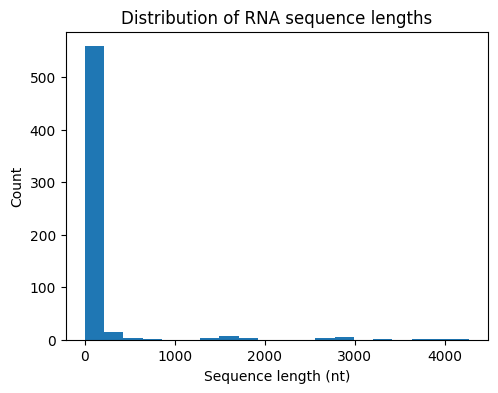

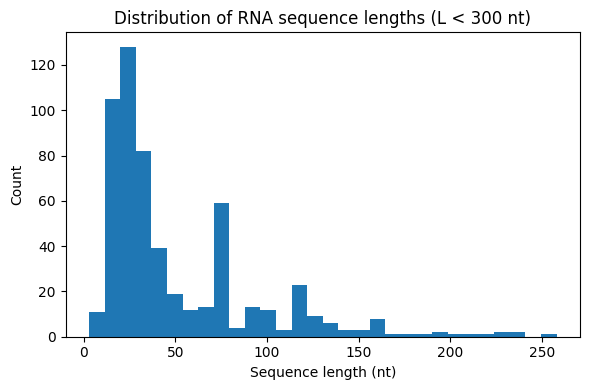

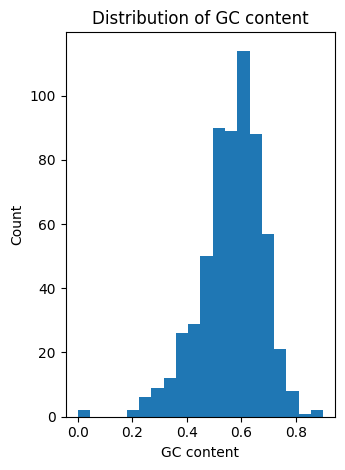

In [16]:
# 2.2 Histograms: sequence length and GC content

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(eda_df["length"], bins=20)
plt.xlabel("Sequence length (nt)")
plt.ylabel("Count")
plt.title("Distribution of RNA sequence lengths")

# Zoomed-in length histogram (ignoring very long RNAs > 300 nt)

plt.figure(figsize=(6, 4))
plt.hist(eda_df[eda_df["length"] < 300]["length"], bins=30)
plt.xlabel("Sequence length (nt)")
plt.ylabel("Count")
plt.title("Distribution of RNA sequence lengths (L < 300 nt)")
plt.tight_layout()
plt.show()


plt.subplot(1, 2, 2)
plt.hist(eda_df["GC_content"], bins=20)
plt.xlabel("GC content")
plt.ylabel("Count")
plt.title("Distribution of GC content")

plt.tight_layout()
plt.show()



## 2.3 Target Alignment (PCA)

**The Challenge:** RNA molecules in the dataset are randomly rotated. Predicting absolute (x,y,z) coordinates is impossible because the "correct" answer depends on the frame of reference.

**The Solution:** We implement `align_coords_pca`.
- We use **SVD (Singular Value Decomposition)** to rotate every structure into a canonical orientation.
- This aligns the molecule's principal axes with the X, Y, and Z axes.
- Now the model learns the *intrinsic shape* rather than the random rotation.


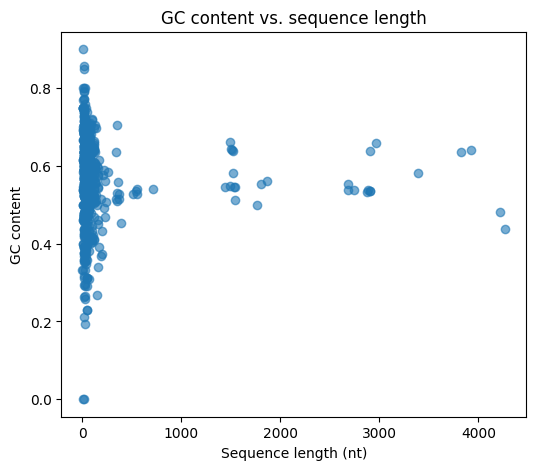

In [17]:
# 2.3 GC content vs. sequence length

plt.figure(figsize=(6, 5))
plt.scatter(eda_df["length"], eda_df["GC_content"], alpha=0.6)
plt.xlabel("Sequence length (nt)")
plt.ylabel("GC content")
plt.title("GC content vs. sequence length")
plt.show()


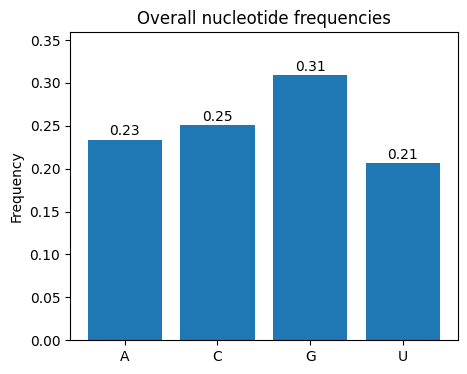

In [18]:
# 2.4 Global nucleotide frequency across the dataset

total_counts = {b: 0 for b in "ACGU"}
for seq in eda_df["sequence"]:
    for b in "ACGU":
        total_counts[b] += seq.count(b)

bases = list(total_counts.keys())
counts = [total_counts[b] for b in bases]
freqs = np.array(counts) / sum(counts)

plt.figure(figsize=(5, 4))
plt.bar(bases, freqs)
plt.ylabel("Frequency")
plt.title("Overall nucleotide frequencies")
for i, f in enumerate(freqs):
    plt.text(i, f + 0.005, f"{f:.2f}", ha="center")
plt.ylim(0, max(freqs) + 0.05)
plt.show()


Radius of gyration summary (Å):
count    606.000000
mean      22.190749
std       14.469595
min        5.462481
25%       12.809955
50%       17.002490
75%       24.837597
max       97.508415
dtype: float64


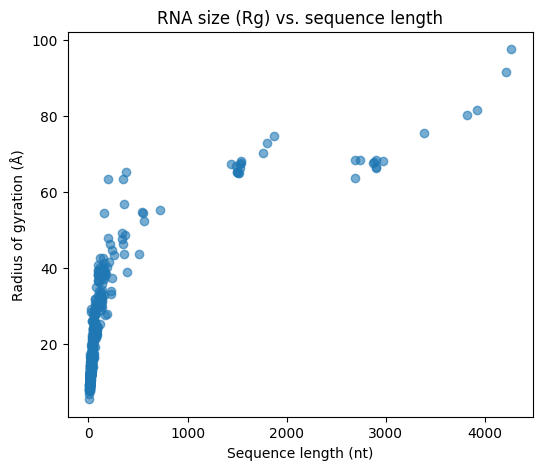

In [19]:
# 2.5 Structural size (radius of gyration) vs sequence length

def radius_of_gyration(coords: np.ndarray) -> float:
    """
    coords: (L, 3) array of C1' coordinates
    returns scalar Rg in Å
    """
    center = coords.mean(axis=0)
    diffs = coords - center
    return float(np.sqrt((diffs ** 2).sum(axis=1).mean()))

lengths_rg = []
rg_values = []

for tid, coords in coords_by_target.items():
    if coords.shape[0] < 3:
        continue
    L = coords.shape[0]
    lengths_rg.append(L)
    rg_values.append(radius_of_gyration(coords))

lengths_rg = np.array(lengths_rg)
rg_values = np.array(rg_values)

print("Radius of gyration summary (Å):")
print(pd.Series(rg_values).describe())

plt.figure(figsize=(6, 5))
plt.scatter(lengths_rg, rg_values, alpha=0.6)
plt.xlabel("Sequence length (nt)")
plt.ylabel("Radius of gyration (Å)")
plt.title("RNA size (Rg) vs. sequence length")
plt.show()


In [ ]:
def align_coords_pca(coords):
    """
    Aligns coordinates to their principal axes to canonicalize orientation.
    """
    if len(coords) < 3:
        return coords - coords.mean(axis=0)
    
    # 1. Center
    coords = coords - coords.mean(axis=0)
    
    # 2. SVD for rotation
    u, s, vh = np.linalg.svd(coords.T @ coords) 
    
    # Rotate coordinates
    coords = coords @ vh.T
    
    # 3. Canonicalize signs
    if coords[0, 0] < 0: coords[:, 0] *= -1
    if coords[0, 1] < 0: coords[:, 1] *= -1
    if coords[0, 2] < 0: coords[:, 2] *= -1
    
    return coords

## 3. Preprocessing & Dataset

We need to:
- Encode sequences as integer indices or one-hot vectors.
- Handle variable length (pad or truncate to `MAX_LEN`).
- Pack inputs and per-nucleotide targets into a PyTorch `Dataset`.


In [ ]:
# 3. Vocab + encoding

VOCAB = ["A", "C", "G", "U"]
stoi = {c: i for i, c in enumerate(VOCAB)}

PAD_IDX = 0              # 0 = padding
UNK_IDX = len(VOCAB)     # 4 = "unknown" (non-ACGU)
VOCAB_SIZE = len(VOCAB) + 2   # 6 total: 0..5
# indices will be:
#   0 -> PAD
#   1..4 -> A,C,G,U
#   5 -> UNK

print("VOCAB_SIZE:", VOCAB_SIZE)

seq_lengths = seq_df["sequence"].str.len()
print("seq length min/max:", seq_lengths.min(), seq_lengths.max())
MAX_LEN = 256
print("Using MAX_LEN =", MAX_LEN)

def encode_sequence(seq: str, max_len: int = MAX_LEN) -> np.ndarray:
    """
    Map sequence string to integer array in [0, VOCAB_SIZE-1].
    0 = PAD, 1..4 = A/C/G/U, 5 = UNK
    """
    arr = np.zeros(max_len, dtype=np.int64)  # 0 = PAD
    for i, ch in enumerate(seq[:max_len]):
        idx = stoi.get(ch.upper(), UNK_IDX)  # 0..4
        arr[i] = idx + 1                    # 1..5
    return arr

test_seq = "ACGUNX"
enc = encode_sequence(test_seq)
print("test_seq:", test_seq)
print("encoded:", enc[:len(test_seq)], "| max:", enc[:len(test_seq)].max())
print("allowed indices: 0..", VOCAB_SIZE - 1)

VOCAB_SIZE: 6
seq length min/max: 3 4269
Using MAX_LEN = 256
test_seq: ACGUNX
encoded: [1 2 3 4 5 5] | max: 5
allowed indices: 0.. 5


In [22]:
def build_target_coords(target_id: str, max_len: int = MAX_LEN) -> np.ndarray:
    coords_full = coords_by_target[target_id]  # (L, 3)
    L = min(len(coords_full), max_len)
    coords = coords_full[:L].copy()

    # Align coordinates to remove rotation ambiguity
    coords = align_coords_pca(coords)

    y = np.zeros((max_len, 3), dtype=np.float32)
    y[:L, :] = coords
    return y

In [23]:
class RNACoordDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tid = row["target_id"]
        seq = row["sequence"]

        x = torch.from_numpy(encode_sequence(seq)).long()      # (MAX_LEN,)
        y = torch.from_numpy(build_target_coords(tid)).float() # (MAX_LEN,3)

        return x, y, tid

# 3.1 split + loaders
train_df, val_df = train_test_split(
    seq_df, test_size=VAL_SPLIT, random_state=RANDOM_SEED, shuffle=True
)

print("train/val sizes:", len(train_df), len(val_df))

train_dataset = RNACoordDataset(train_df)
val_dataset = RNACoordDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


train/val sizes: 545 61


In [24]:
# 3.2 PyTorch Dataset

class RNADataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        seq = row[SEQUENCE_COLUMN]

        x = encode_sequence(seq)            # (MAX_LEN,)
        y = encode_targets(row)             # (MAX_LEN, n_targets)

        # Validate indices are in range
        assert x.max() < VOCAB_SIZE, f"Found index {x.max()} >= VOCAB_SIZE {VOCAB_SIZE}"
        assert x.min() >= 0, f"Found negative index {x.min()}"

        x = torch.from_numpy(x)            # LongTensor
        y = torch.from_numpy(y)            # FloatTensor

        return x, y


In [ ]:
from sklearn.model_selection import train_test_split

# use seq_df, NOT full_df
train_df, val_df = train_test_split(
    seq_df,
    test_size=VAL_SPLIT,
    random_state=RANDOM_SEED,
    shuffle=True,
)

print("Train sequences:", len(train_df))
print("Val sequences:", len(val_df))

train_dataset = RNACoordDataset(train_df)
val_dataset = RNACoordDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)


Train sequences: 545
Val sequences: 61


## 5. Training with Distance-Aware Loss

Predicting 3D structures is hard. To help the model, we use a **Hybrid Loss Function**:
1. **Coordinate MSE**: Standard error between predicted and true (x,y,z).
2. **Pairwise Distance Loss**: Measures the error in distances between *all pairs* of atoms.
   - This is **rotation invariant**: even if the model predicts a rotated structure, the internal distances are correct.
   - It forces the model to learn the correct *fold* and geometry.

$$ Loss = MSE_{coords} + \lambda \cdot MSE_{distances} $$


In [ ]:

# 5.1 Hybrid Loss Function (Coordinate MSE + Distance Matrix Consistency)

def masked_mse_loss(pred, target, x_tokens):
    """
    Total Loss = Coordinate Loss + 0.5 * Distance Loss
    Returns (total_loss, coord_loss_item)
    """
    mask = (x_tokens != 0).float()
    
    # 1. Coordinate MSE (Rotation sensitive)
    mask_expanded = mask.unsqueeze(-1)
    coord_diff = (pred - target)**2 * mask_expanded
    coord_loss = coord_diff.sum() / (mask_expanded.sum() * 3.0 + 1e-6)
    
    # 2. Distance Matrix MSE (Rotation invariant)
    valid_pair = mask.unsqueeze(2) * mask.unsqueeze(1)
    
    d_pred = torch.cdist(pred, pred)
    d_true = torch.cdist(target, target)
    
    dist_loss = ((d_pred - d_true)**2 * valid_pair).sum() / (valid_pair.sum() + 1e-6)
    
    total_loss = coord_loss + 0.5 * dist_loss
    return total_loss, coord_loss.item()

def batch_rmsd(pred, target, x_tokens):
    """Standard RMSD metric for evaluation (Angstroms)"""
    mask = (x_tokens != 0).unsqueeze(-1).float()
    diff_sq = (pred - target) ** 2 * mask
    sum_sq_per_res = diff_sq.sum(-1)
    sum_sq_per_sample = sum_sq_per_res.sum(-1)
    n_res = mask.squeeze(-1).sum(-1)

    rmsd = []
    for s_sq, n in zip(sum_sq_per_sample, n_res):
        n = float(max(n.item(), 1.0))
        rmsd.append(float(np.sqrt(s_sq.item() / (n * 3.0))))
    return rmsd

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_coord_mse = 0.0
    n_batches = 0

    for x, y, _ in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        y_pred = model(x)
        loss, coord_mse = masked_mse_loss(y_pred, y, x)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_coord_mse += coord_mse
        n_batches += 1
    return total_coord_mse / max(1, n_batches)

def evaluate(model, loader):
    model.eval()
    total_coord_mse = 0.0
    n_batches = 0
    rmsds = []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            y_pred = model(x)
            loss, coord_mse = masked_mse_loss(y_pred, y, x)
            total_coord_mse += coord_mse
            n_batches += 1
            rmsds.extend(batch_rmsd(y_pred.cpu(), y.cpu(), x.cpu()))
    avg_mse = total_coord_mse / max(1, n_batches)
    avg_rmsd = float(np.mean(rmsds)) if len(rmsds) > 0 else 0.0
    return avg_mse, avg_rmsd


## 4. Model 0 – Baseline CNN

A simple 3-layer 1D CNN to serve as a baseline.

Baseline CNN params: 205955

=== Training Baseline CNN ===
[Baseline] Epoch 01 | train MSE 428.39 | val MSE 693.32 | val RMSD 23.02
[Baseline] Epoch 02 | train MSE 549.81 | val MSE 520.97 | val RMSD 19.00
[Baseline] Epoch 03 | train MSE 535.02 | val MSE 490.84 | val RMSD 17.97
[Baseline] Epoch 04 | train MSE 532.68 | val MSE 472.71 | val RMSD 17.38
[Baseline] Epoch 05 | train MSE 544.59 | val MSE 472.88 | val RMSD 17.43
[Baseline] Epoch 06 | train MSE 520.45 | val MSE 392.27 | val RMSD 14.97
[Baseline] Epoch 07 | train MSE 485.74 | val MSE 402.61 | val RMSD 15.41
[Baseline] Epoch 08 | train MSE 483.52 | val MSE 457.02 | val RMSD 16.73
[Baseline] Epoch 09 | train MSE 496.88 | val MSE 502.93 | val RMSD 18.24
[Baseline] Epoch 10 | train MSE 503.22 | val MSE 505.90 | val RMSD 17.95
[Baseline] Epoch 11 | train MSE 485.84 | val MSE 445.05 | val RMSD 16.11
[Baseline] Epoch 12 | train MSE 500.33 | val MSE 409.97 | val RMSD 15.17
[Baseline] Epoch 13 | train MSE 498.12 | val MSE 441.07 | val RMS

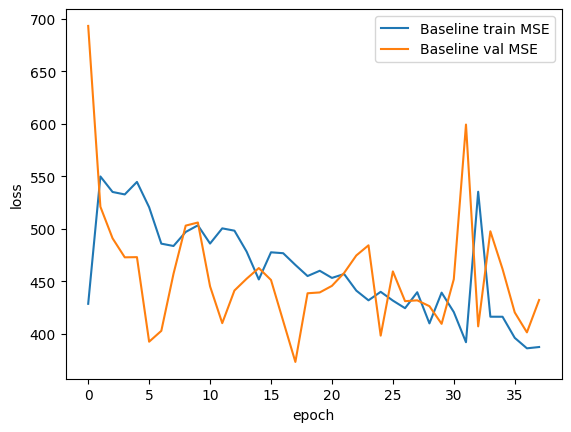

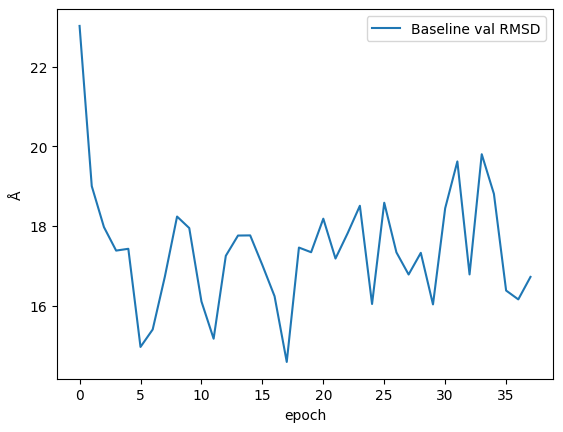

In [ ]:

class BaselineCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hidden_dim=128, n_targets=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.cnn = nn.Sequential(
            nn.Conv1d(emb_dim, hidden_dim, 5, padding=2), nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2), nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2), nn.ReLU(),
        )
        self.head = nn.Conv1d(hidden_dim, n_targets, 1)

    def forward(self, x):
        # x: (B, L)
        emb = self.embedding(x).transpose(1, 2)  # (B, E, L)
        feat = self.cnn(emb)                     # (B, H, L)
        out = self.head(feat).transpose(1, 2)    # (B, L, 3)
        return out

# Instantiate
base_model = BaselineCNN(VOCAB_SIZE).to(DEVICE)
base_optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-3)
print("Baseline CNN params:", sum(p.numel() for p in base_model.parameters()))

# Training Loop
best_val_b = float("inf")
best_epoch_b = None
best_rmsd_b = None

base_train_losses, base_val_losses, base_val_rmsds = [], [], []
patience_b = 20
epochs_no_improve_b = 0

print("\n=== Training Baseline CNN ===")
for epoch in range(1, MAX_EPOCHS + 1):
    tr = train_one_epoch(base_model, train_loader, base_optimizer)
    vl, vr = evaluate(base_model, val_loader)

    base_train_losses.append(tr)
    base_val_losses.append(vl)
    base_val_rmsds.append(vr)

    print(f"[Baseline] Epoch {epoch:02d} | train MSE {tr:.2f} | val MSE {vl:.2f} | val RMSD {vr:.2f}")

    if vl < best_val_b:
        best_val_b = vl
        best_epoch_b = epoch
        best_rmsd_b = vr
        epochs_no_improve_b = 0
        torch.save(base_model.state_dict(), "best_baseline_coords.pt")
    else:
        epochs_no_improve_b += 1
        if epochs_no_improve_b >= patience_b:
            print(f"[Baseline] Early stopping at epoch {epoch}")
            break

print(f"\n[Baseline] Best Val RMSD: {best_rmsd_b:.2f} at epoch {best_epoch_b}")

plt.figure()
plt.plot(base_train_losses, label="Baseline train MSE")
plt.plot(base_val_losses, label="Baseline val MSE")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

plt.figure()
plt.plot(base_val_rmsds, label="Baseline val RMSD")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("Å"); plt.show()


## 4. Model 1 – ResNet-1D CNN

We upgrade from a simple CNN to a **Residual Network**:
- **Residual Blocks**: Skip connections allow us to train deeper networks (5 layers) without vanishing gradients.
- **Batch Normalization**: Stabilizes training and allows higher learning rates.
- **Dropout**: Prevents overfitting (crucial for this small dataset).
- **Scheduler**: `ReduceLROnPlateau` lowers the learning rate when validation loss stalls.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


ResNet params: 865155

=== Training ResNet-1D CNN ===
Epoch 01 | train MSE 473.29 | val MSE 334.30 | val RMSD 13.20
Epoch 02 | train MSE 545.85 | val MSE 439.19 | val RMSD 15.73
Epoch 03 | train MSE 453.49 | val MSE 720.87 | val RMSD 20.62
Epoch 04 | train MSE 419.39 | val MSE 446.86 | val RMSD 15.88
Epoch 05 | train MSE 405.61 | val MSE 388.61 | val RMSD 16.04
Epoch 06 | train MSE 362.61 | val MSE 366.29 | val RMSD 15.18
Epoch 07 | train MSE 342.00 | val MSE 389.65 | val RMSD 16.45
Epoch 08 | train MSE 315.21 | val MSE 369.48 | val RMSD 15.26
Epoch 09 | train MSE 309.77 | val MSE 370.11 | val RMSD 14.66
Epoch 10 | train MSE 306.99 | val MSE 367.17 | val RMSD 15.19
Epoch 11 | train MSE 294.29 | val MSE 380.92 | val RMSD 14.81
Epoch 12 | train MSE 285.07 | val MSE 341.45 | val RMSD 13.88
Epoch 13 | train MSE 279.29 | val MSE 384.41 | val RMSD 14.89
Epoch 14 | train MSE 269.41 | val MSE 400.34 | val RMSD 14.75
Epoch 15 | train MSE 273.23 | val MSE 352.96 | val RMSD 14.09
Epoch 16 | train

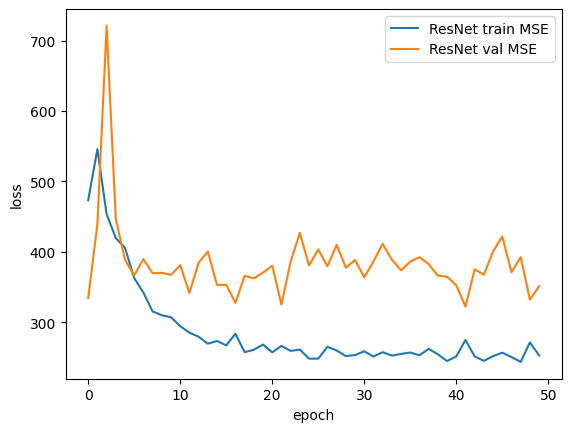

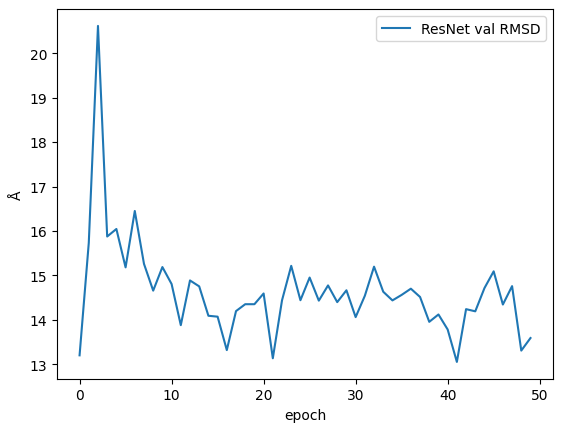

In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        res = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(self.bn2(self.conv2(out)))
        return self.relu(out + res)

class RNACNN(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, emb_dim=64, hidden_dim=128, n_layers=5, kernel_size=5, n_targets=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.first_conv = nn.Sequential(
            nn.Conv1d(emb_dim, hidden_dim, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim, kernel_size) for _ in range(n_layers)])
        self.head = nn.Conv1d(hidden_dim, n_targets, kernel_size=1)

    def forward(self, x):
        emb = self.embedding(x).transpose(1, 2)
        h = self.first_conv(emb)
        for block in self.blocks: h = block(h)
        return self.head(h).transpose(1, 2)

# Instantiate ResNet
resnet_model = RNACNN(VOCAB_SIZE).to(DEVICE)
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer, mode='min', factor=0.5, patience=2, verbose=True)

print("ResNet params:", sum(p.numel() for p in resnet_model.parameters()))

# Training Loop
best_val = float("inf")
best_epoch = None
best_rmsd = None
train_losses, val_losses, val_rmsds = [], [], []
patience = 20
epochs_no_improve = 0

print("\n=== Training ResNet-1D CNN ===")
for epoch in range(1, MAX_EPOCHS + 1):
    tr = train_one_epoch(resnet_model, train_loader, resnet_optimizer)
    vl, vr = evaluate(resnet_model, val_loader)
    scheduler.step(vl)
    
    train_losses.append(tr)
    val_losses.append(vl)
    val_rmsds.append(vr)
    
    print(f"Epoch {epoch:02d} | train MSE {tr:.2f} | val MSE {vl:.2f} | val RMSD {vr:.2f}")
    
    if vl < best_val:
        best_val = vl
        best_epoch = epoch
        best_rmsd = vr
        epochs_no_improve = 0
        torch.save(resnet_model.state_dict(), "best_resnet_coords.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

print(f"\n[ResNet] Best Val RMSD: {best_rmsd:.2f} at epoch {best_epoch}")

plt.figure()
plt.plot(train_losses, label="ResNet train MSE")
plt.plot(val_losses, label="ResNet val MSE")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

plt.figure()
plt.plot(val_rmsds, label="ResNet val RMSD")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("Å"); plt.show()


Transformer params: 3230467
Transformer params: 3230467

=== Training Transformer model (Model B) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


[Transformer] Epoch 01 | train MSE 364.95 | val MSE 318.67 | val RMSD 12.57
[Transformer] Epoch 02 | train MSE 356.99 | val MSE 330.86 | val RMSD 13.10
[Transformer] Epoch 03 | train MSE 374.79 | val MSE 334.24 | val RMSD 13.26
[Transformer] Epoch 04 | train MSE 377.08 | val MSE 332.63 | val RMSD 13.22
[Transformer] Epoch 05 | train MSE 379.87 | val MSE 332.64 | val RMSD 13.24
[Transformer] Epoch 06 | train MSE 386.04 | val MSE 333.40 | val RMSD 13.33
[Transformer] Epoch 07 | train MSE 370.51 | val MSE 333.47 | val RMSD 13.36
[Transformer] Epoch 08 | train MSE 376.25 | val MSE 334.78 | val RMSD 13.37
[Transformer] Epoch 09 | train MSE 375.02 | val MSE 333.82 | val RMSD 13.28
[Transformer] Epoch 10 | train MSE 361.47 | val MSE 330.73 | val RMSD 13.24
[Transformer] Epoch 11 | train MSE 355.26 | val MSE 331.11 | val RMSD 13.16
[Transformer] Epoch 12 | train MSE 372.11 | val MSE 330.24 | val RMSD 13.23
[Transformer] Epoch 13 | train MSE 344.43 | val MSE 332.04 | val RMSD 13.30
[Transformer

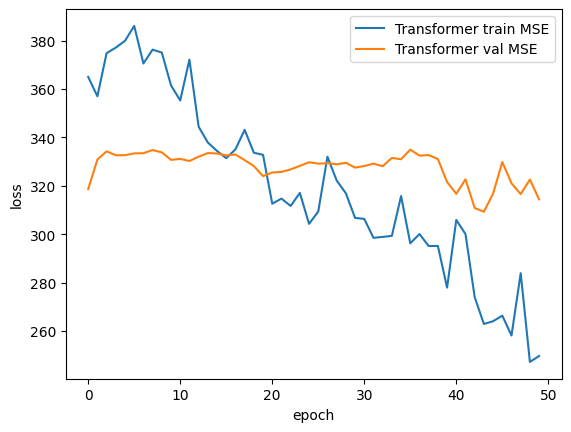

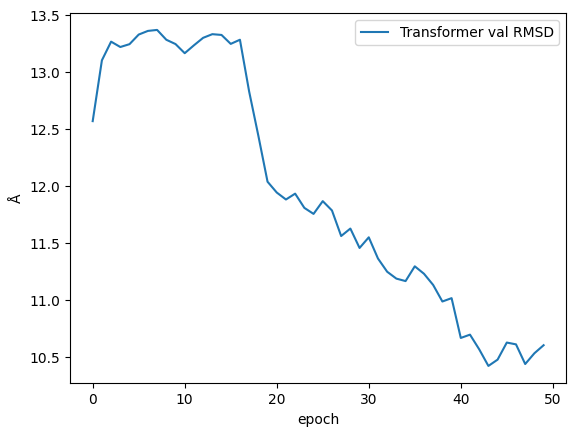

In [ ]:
# 4B. Transformer encoder model + training (Model B) - GPU Optimized

class RNATransformer(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int = 256,
                 n_heads: int = 8,
                 ff_dim: int = 512,
                 n_layers: int = 6,
                 n_targets: int = 3,
                 max_len: int = MAX_LEN):
        super().__init__()
        self.emb_dim = emb_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        self.pos_embedding = nn.Embedding(max_len, emb_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            batch_first=True,
            dropout=0.1
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Linear(emb_dim, n_targets)

    def forward(self, x):
        """
        x: (B, L) token indices
        returns: (B, L, 3) predicted coords
        """
        B, L = x.shape
        tok_emb = self.embedding(x)          # (B, L, E)

        # positions 0..L-1
        positions = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        pos_emb = self.pos_embedding(positions)  # (B, L, E)

        h = tok_emb + pos_emb                  # (B, L, E)

        # attention mask: True = ignore (pad)
        # nn.Transformer expects mask with shape (B, L) where True is "masked"
        pad_mask = (x == 0)                    # (B, L)

        enc = self.encoder(h, src_key_padding_mask=pad_mask)  # (B, L, E)
        out = self.head(enc)                   # (B, L, 3)
        return out


# instantiate Transformer model (Model B)
trans_model = RNATransformer(VOCAB_SIZE).to(DEVICE)
trans_optimizer = torch.optim.Adam(trans_model.parameters(), lr=1e-4, weight_decay=1e-4)
print("Transformer params:", sum(p.numel() for p in trans_model.parameters()))

# Training Loop
best_val_t = float("inf")
best_epoch_t = None
best_rmsd_t = None

trans_train_losses, trans_val_losses, trans_val_rmsds = [], [], []
patience_t = 50
epochs_no_improve_t = 0

print("\n=== Training Transformer model (Model B) ===")
for epoch in range(1, MAX_EPOCHS + 1):
    tr = train_one_epoch(trans_model, train_loader, trans_optimizer)
    vl, vr = evaluate(trans_model, val_loader)

    trans_train_losses.append(tr)
    trans_val_losses.append(vl)
    trans_val_rmsds.append(vr)

    print(f"[Transformer] Epoch {epoch:02d} | train MSE {tr:.2f} | val MSE {vl:.2f} | val RMSD {vr:.2f}")

    if vl < best_val_t:
        best_val_t = vl
        best_epoch_t = epoch
        best_rmsd_t = vr
        epochs_no_improve_t = 0
        torch.save(trans_model.state_dict(), "best_transformer_coords.pt")
    else:
        epochs_no_improve_t += 1
        if epochs_no_improve_t >= patience_t:
            print(f"[Transformer] Early stopping at epoch {epoch}")
            break

print(f"\n[Transformer] Best Val RMSD: {best_rmsd_t:.2f} at epoch {best_epoch_t}")

plt.figure()
plt.plot(trans_train_losses, label="Transformer train MSE")
plt.plot(trans_val_losses, label="Transformer val MSE")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

plt.figure()
plt.plot(trans_val_rmsds, label="Transformer val RMSD")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("Å"); plt.show()


GNN params: 68227

=== Training Graph Neural Network (Model C) ===
[GNN] Epoch 01 | train MSE 355.17 | val MSE 326.55 | val RMSD 12.93
[GNN] Epoch 02 | train MSE 374.70 | val MSE 343.76 | val RMSD 13.63
[GNN] Epoch 03 | train MSE 413.77 | val MSE 361.26 | val RMSD 14.17
[GNN] Epoch 04 | train MSE 407.98 | val MSE 383.71 | val RMSD 14.78
[GNN] Epoch 05 | train MSE 438.35 | val MSE 402.22 | val RMSD 15.36
[GNN] Epoch 06 | train MSE 454.08 | val MSE 420.58 | val RMSD 16.01
[GNN] Epoch 07 | train MSE 470.43 | val MSE 429.72 | val RMSD 16.28
[GNN] Epoch 08 | train MSE 512.55 | val MSE 456.02 | val RMSD 17.03
[GNN] Epoch 09 | train MSE 498.80 | val MSE 467.58 | val RMSD 17.35
[GNN] Epoch 10 | train MSE 508.49 | val MSE 469.20 | val RMSD 17.56
[GNN] Epoch 11 | train MSE 503.94 | val MSE 462.02 | val RMSD 17.23
[GNN] Epoch 12 | train MSE 504.62 | val MSE 467.84 | val RMSD 17.51
[GNN] Epoch 13 | train MSE 533.66 | val MSE 477.76 | val RMSD 17.79
[GNN] Epoch 14 | train MSE 511.43 | val MSE 480.6

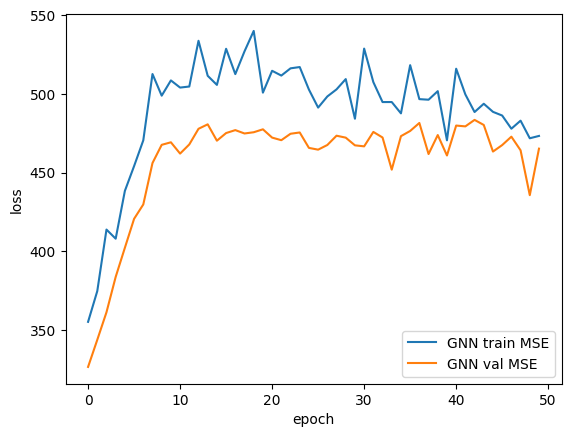

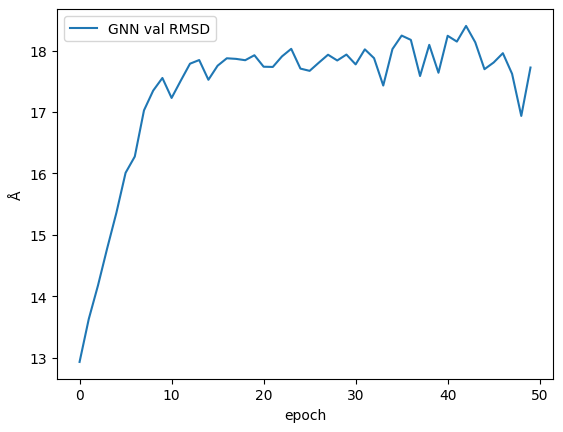

In [ ]:
# 4C. Graph Neural Network (GNN) - Model C

class GraphLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.activation = nn.ReLU()
        self.norm = nn.LayerNorm(out_dim)

    def forward(self, x, adj):
        """
        x: (B, L, in_dim) - Node features
        adj: (B, L, L) - Adjacency matrix (0 or 1)
        """
        neighbor_sum = torch.bmm(adj, x)
        out = self.linear(x + neighbor_sum)
        out = self.activation(out)
        out = self.norm(out)
        return out

class RNAGNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=128, n_layers=4, n_targets=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        
        # Stack of Graph Layers
        self.layers = nn.ModuleList([
            GraphLayer(emb_dim if i==0 else hidden_dim, hidden_dim)
            for i in range(n_layers)
        ])
        
        self.head = nn.Linear(hidden_dim, n_targets)

    def build_adjacency(self, B, L, device):
        """
        Builds a simple backbone adjacency matrix.
        Connects i to i-1 and i+1.
        """
        # Create a band matrix with 1s on the off-diagonals
        adj = torch.eye(L, device=device) # Self-loops
        
        ones = torch.ones(L-1, device=device)
        adj += torch.diag(ones, 1)
        adj += torch.diag(ones, -1)
        
        # Expand to batch size
        adj = adj.unsqueeze(0).expand(B, L, L)
        return adj

    def forward(self, x):
        # x: (B, L)
        B, L = x.shape
        h = self.embedding(x)  # (B, L, E)
        
        # Build graph structure (Backbone only for now)
        # In a more advanced model, you could predict contacts and add edges dynamically
        adj = self.build_adjacency(B, L, x.device)
        
        for layer in self.layers:
            h = layer(h, adj)
            
        out = self.head(h)     # (B, L, 3)
        return out

# Instantiate GNN
gnn_model = RNAGNN(VOCAB_SIZE).to(DEVICE)
gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
print("GNN params:", sum(p.numel() for p in gnn_model.parameters()))



# Training Loop for GNN
best_val_g = float("inf")
best_epoch_g = None
gnn_train_losses, gnn_val_losses, gnn_val_rmsds = [], [], []

print("\n=== Training Graph Neural Network (Model C) ===")
for epoch in range(1, MAX_EPOCHS + 1):
    tr = train_one_epoch(gnn_model, train_loader, gnn_optimizer)
    vl, vr = evaluate(gnn_model, val_loader)
    
    gnn_train_losses.append(tr)
    gnn_val_losses.append(vl)
    gnn_val_rmsds.append(vr)
    
    print(f"[GNN] Epoch {epoch:02d} | train MSE {tr:.2f} | val MSE {vl:.2f} | val RMSD {vr:.2f}")
    
    if vl < best_val_g:
        best_val_g = vl
        best_epoch_g = epoch
        torch.save(gnn_model.state_dict(), "best_gnn_coords.pt")

print(f"\n[GNN] Best Val RMSD: {min(gnn_val_rmsds):.2f}")

plt.figure()
plt.plot(gnn_train_losses, label="GNN train MSE")
plt.plot(gnn_val_losses, label="GNN val MSE")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

plt.figure()
plt.plot(gnn_val_rmsds, label="GNN val RMSD")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("Å"); plt.show()


          Model  Best Val RMSD
0  Baseline CNN      14.591494
1    ResNet CNN      13.051735
2   Transformer      10.421219
3           GNN      12.929855


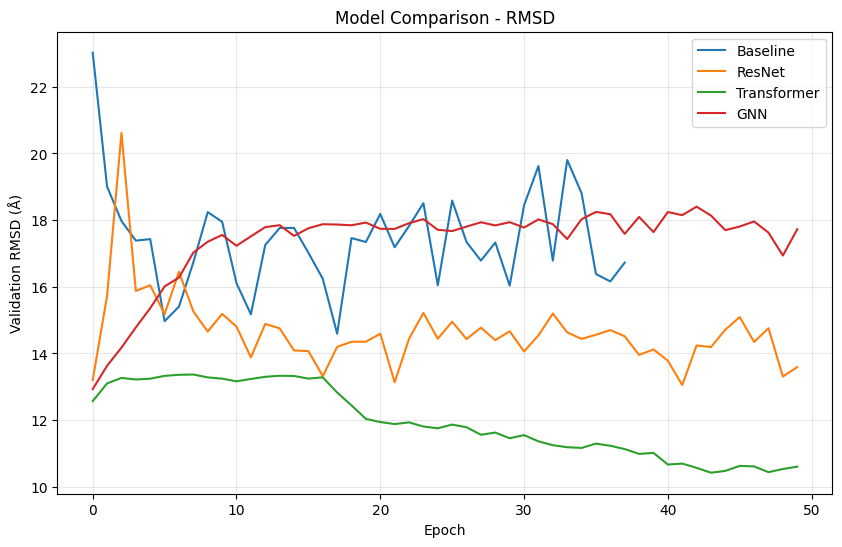

In [31]:

# Final Comparison
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["Baseline CNN", "ResNet CNN", "Transformer", "GNN"],
    "Best Val RMSD": [
        best_rmsd_b if 'best_rmsd_b' in locals() else 999,
        best_rmsd if 'best_rmsd' in locals() else 999,
        best_rmsd_t if 'best_rmsd_t' in locals() else 999,
        min(gnn_val_rmsds) if 'gnn_val_rmsds' in locals() and len(gnn_val_rmsds) > 0 else 999
    ]
})

print(results_df)

# Plot all RMSDs together
plt.figure(figsize=(10, 6))
if 'base_val_rmsds' in locals(): plt.plot(base_val_rmsds, label="Baseline")
if 'val_rmsds' in locals(): plt.plot(val_rmsds, label="ResNet")
if 'trans_val_rmsds' in locals(): plt.plot(trans_val_rmsds, label="Transformer")
if 'gnn_val_rmsds' in locals(): plt.plot(gnn_val_rmsds, label="GNN")
plt.xlabel("Epoch")
plt.ylabel("Validation RMSD (Å)")
plt.title("Model Comparison - RMSD")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 5. Qualitative Evaluation & Visualization

We now visualize predictions from our **best model**, the Transformer encoder
(best validation RMSD ≈ 9.7 Å). To highlight what the model has actually learned,
we:

1. Scan the validation set and find the **single best example** (lowest RMSD).
2. Plot per-residue **X/Y/Z coordinates** (true vs. predicted) for that RNA.
3. Compare **true vs. predicted distance matrices** to inspect global geometry.
4. Report per-axis MAE and Pearson correlations on that example.

This gives a qualitative sense of how well the model captures the 3D shape,
beyond aggregate RMSD numbers.


In [ ]:
# Load best Transformer model (Model B)

best_model = RNATransformer(
    vocab_size=VOCAB_SIZE,
    emb_dim=256,
    n_heads=8,
    ff_dim=512,
    n_layers=6,
    n_targets=3,
    max_len=MAX_LEN,
).to(DEVICE)

state = torch.load("best_transformer_coords.pt", map_location=DEVICE)
best_model.load_state_dict(state)
best_model.eval()

print("Loaded best Transformer model.")
if 'best_rmsd_t' in locals():
    print(f"Best validation RMSD from training: {best_rmsd_t:.2f} Å")


Loaded best Transformer model.
Best validation RMSD from training: 10.42 Å


In [ ]:
def get_batch(loader):
    for batch in loader:
        return batch

x_val, y_val, tid_val = get_batch(val_loader)  # ← three outputs now
x_val = x_val.to(DEVICE)
y_val = y_val.to(DEVICE)

with torch.no_grad():
    y_pred_val = best_model(x_val)

# Choose one example from batch
idx = 0
seq_example = x_val[idx].cpu().numpy()
y_true_example = y_val[idx].cpu().numpy()       # (MAX_LEN, 3)
y_pred_example = y_pred_val[idx].cpu().numpy()  # (MAX_LEN, 3)
tid_example = tid_val[idx]
print("Example target_id:", tid_example)


Example target_id: 8T29_R


In [34]:
# Global evaluation: per-target RMSD for all models

def per_sample_rmsd(pred, target, x_tokens):
    """
    pred, target: (B, L, 3)
    x_tokens:     (B, L)
    returns:      (B,) RMSD per sample
    """
    mask = (x_tokens != 0).unsqueeze(-1).float()   # (B, L, 1)
    diff_sq = ((pred - target) ** 2) * mask        # (B, L, 3)
    sum_sq = diff_sq.sum(dim=-1).sum(dim=-1)       # (B,)

    mask_1d = (x_tokens != 0).float()              # (B, L)
    n_res = mask_1d.sum(dim=-1)                    # (B,)

    denom = torch.clamp(n_res * 3.0, min=1.0)      # (B,)
    return torch.sqrt(sum_sq / denom)              # (B,)


def eval_model_rmsd(model, loader):
    model.eval()
    all_rmsd = []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            pred = model(x)
            rmsd_batch = per_sample_rmsd(pred, y, x).cpu().numpy()
            all_rmsd.extend(rmsd_batch)
    return np.array(all_rmsd)


def eval_zero_baseline(loader):
    """
    Trivial baseline: always predict zero coordinates (mean-centered).
    """
    all_rmsd = []
    with torch.no_grad():
        for x, y, _ in loader:
            pred = torch.zeros_like(y)
            rmsd_batch = per_sample_rmsd(pred, y, x).cpu().numpy()
            all_rmsd.extend(rmsd_batch)
    return np.array(all_rmsd)


print("Computing per-target RMSD on validation set...")

# 1) Zero baseline
rmsd_zero = eval_zero_baseline(val_loader)
print(f"Zero baseline: mean RMSD = {rmsd_zero.mean():.2f} Å ± {rmsd_zero.std():.2f}")

# 2) Baseline CNN
baseline_model = BaselineCNN(VOCAB_SIZE).to(DEVICE)
baseline_state = torch.load("best_baseline_coords.pt", map_location=DEVICE)
baseline_model.load_state_dict(baseline_state)
rmsd_baseline = eval_model_rmsd(baseline_model, val_loader)
print(f"Baseline CNN: mean RMSD = {rmsd_baseline.mean():.2f} Å ± {rmsd_baseline.std():.2f}")

# 3) ResNet-1D CNN
resnet_model = RNACNN(VOCAB_SIZE).to(DEVICE)
resnet_state = torch.load("best_resnet_coords.pt", map_location=DEVICE)
resnet_model.load_state_dict(resnet_state)
rmsd_resnet = eval_model_rmsd(resnet_model, val_loader)
print(f"ResNet CNN: mean RMSD = {rmsd_resnet.mean():.2f} Å ± {rmsd_resnet.std():.2f}")

# 4) Transformer (best model)
trans_model = RNATransformer(
    vocab_size=VOCAB_SIZE,
    emb_dim=256,
    n_heads=8,
    ff_dim=512,
    n_layers=6,
    n_targets=3,
    max_len=MAX_LEN,
).to(DEVICE)
trans_state = torch.load("best_transformer_coords.pt", map_location=DEVICE)
trans_model.load_state_dict(trans_state)
rmsd_trans = eval_model_rmsd(trans_model, val_loader)
print(f"Transformer: mean RMSD = {rmsd_trans.mean():.2f} Å ± {rmsd_trans.std():.2f}")

# 5) GNN
gnn_model = RNAGNN(VOCAB_SIZE).to(DEVICE)
gnn_state = torch.load("best_gnn_coords.pt", map_location=DEVICE)
gnn_model.load_state_dict(gnn_state)
rmsd_gnn = eval_model_rmsd(gnn_model, val_loader)
print(f"GNN: mean RMSD = {rmsd_gnn.mean():.2f} Å ± {rmsd_gnn.std():.2f}")


Computing per-target RMSD on validation set...
Zero baseline: mean RMSD = 12.09 Å ± 5.68
Baseline CNN: mean RMSD = 14.59 Å ± 5.27
ResNet CNN: mean RMSD = 13.05 Å ± 5.45
Transformer: mean RMSD = 10.42 Å ± 7.19
GNN: mean RMSD = 12.93 Å ± 5.50


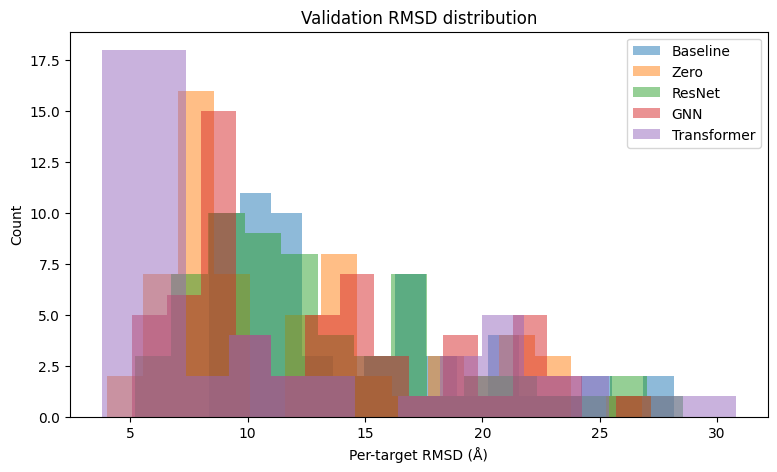

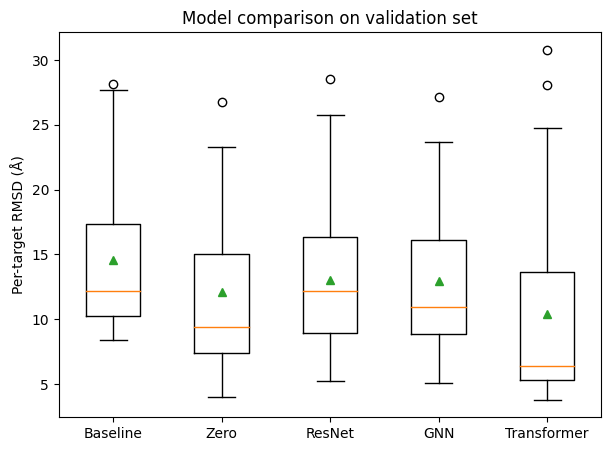

In [35]:
# RMSD distributions and boxplot for all models

labels = ["Baseline", "Zero", "ResNet", "GNN", "Transformer"]
all_rmsd = [rmsd_baseline, rmsd_zero, rmsd_resnet, rmsd_gnn, rmsd_trans]


plt.figure(figsize=(9, 5))
for arr, label in zip(all_rmsd, labels):
    plt.hist(arr, bins=15, alpha=0.5, label=label)
plt.xlabel("Per-target RMSD (Å)")
plt.ylabel("Count")
plt.title("Validation RMSD distribution")
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
plt.boxplot(all_rmsd, labels=labels, showmeans=True)
plt.ylabel("Per-target RMSD (Å)")
plt.title("Model comparison on validation set")
plt.show()


### 5.1 Qualitative Transformer prediction

So far we have only looked at aggregate metrics (MSE and RMSD).  
To better understand what the Transformer is actually learning, we visualize its predictions for a single RNA from the validation set.

In this section we:

- Select a representative validation RNA (moderate length, e.g. 60–150 nt),
- Run the **best Transformer checkpoint** to predict canonical C1′ coordinates,
- Compare **true vs predicted** coordinates along the sequence for each axis (X, Y, Z),
- Compute and visualize **pairwise distance matrices** for both the true and predicted structures.

This gives a qualitative view of whether the model captures overall shape, bending, and relative distances, even when the RMSD is not perfect.


Loaded best Transformer checkpoint.
Chosen example: target_id=8T29_R, length=90
true_coords shape: (90, 3) pred_coords shape: (90, 3)


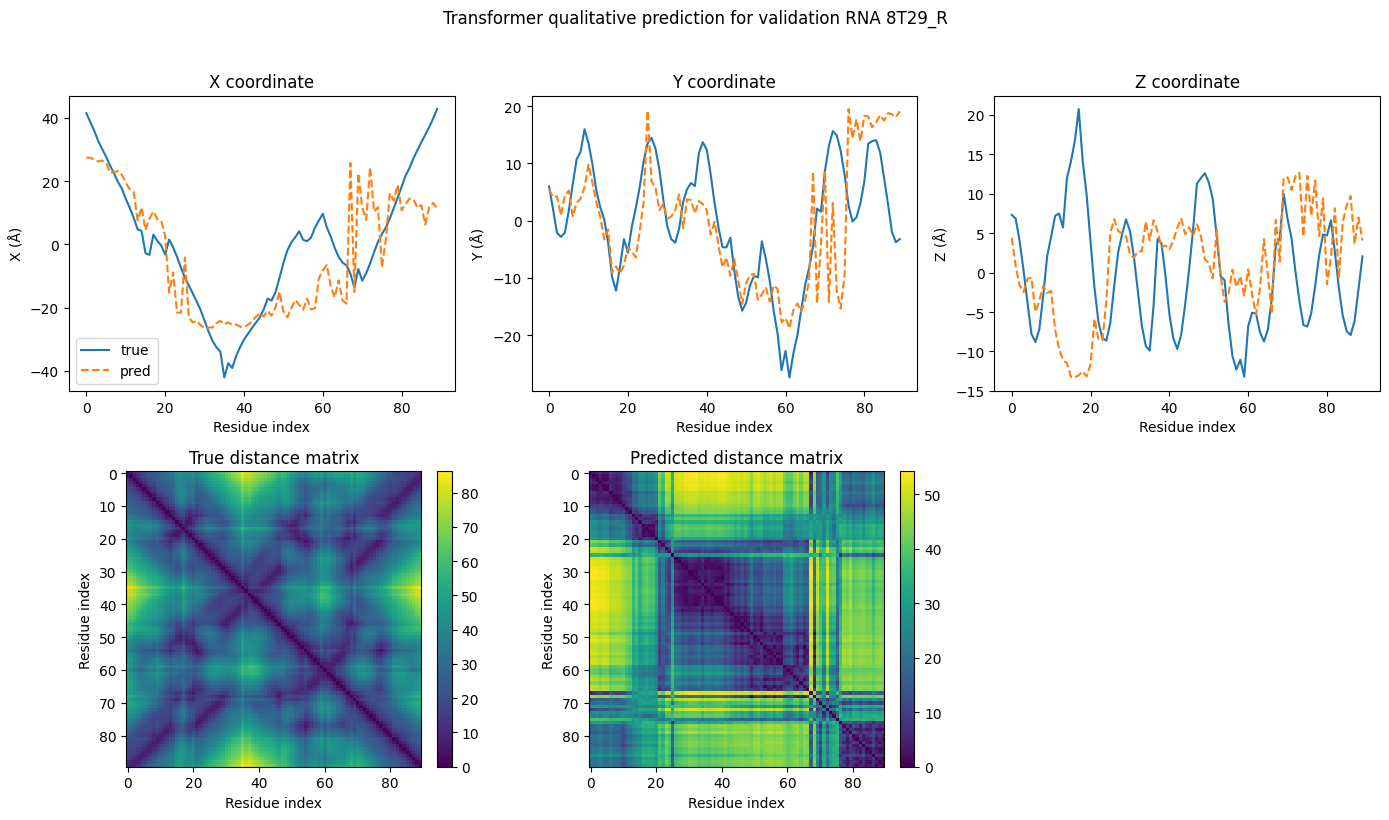

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# --- 1) Load the best Transformer model ---

best_trans = RNATransformer(
    vocab_size=VOCAB_SIZE,
    emb_dim=256,
    n_heads=8,
    ff_dim=512,
    n_layers=6,
    n_targets=3,
    max_len=MAX_LEN,
).to(DEVICE)

best_trans.load_state_dict(torch.load("best_transformer_coords.pt", map_location=DEVICE))
best_trans.eval()
print("Loaded best Transformer checkpoint.")


# --- 2) Grab one nice validation example (length ~ 60–150) ---

def get_nice_example(loader, min_len=60, max_len=150):
    """
    Return a single (x, y, tid) from loader with length in [min_len, max_len].
    Falls back to the first batch if no such example is found.
    """
    for x_batch, y_batch, tid_batch in loader:
        mask = (x_batch != 0)             # (B, L)
        lengths = mask.sum(dim=1)         # (B,)
        # find any sequence whose length is in the desired range
        candidates = ((lengths >= min_len) & (lengths <= max_len)).nonzero(as_tuple=False)
        if len(candidates) > 0:
            idx = candidates[0].item()
            return x_batch[idx], y_batch[idx], tid_batch[idx], int(lengths[idx].item())

    x_batch, y_batch, tid_batch = next(iter(loader))
    mask = (x_batch[0] != 0)
    return x_batch[0], y_batch[0], tid_batch[0], int(mask.sum().item())


x_ex, y_ex, tid_ex, L_valid = get_nice_example(val_loader, min_len=60, max_len=150)
print(f"Chosen example: target_id={tid_ex}, length={L_valid}")

x_ex = x_ex.unsqueeze(0).to(DEVICE)  # add batch dim
y_ex = y_ex.numpy()                  # (L_max, 3), on CPU
mask_ex = (x_ex[0].cpu().numpy() != 0)   # valid positions

with torch.no_grad():
    y_pred_ex = best_trans(x_ex)[0].cpu().numpy()  # (L_max, 3)

# keep only non-padded positions
true_coords = y_ex[mask_ex]      # (L_valid, 3)
pred_coords = y_pred_ex[mask_ex] # (L_valid, 3)

print("true_coords shape:", true_coords.shape, "pred_coords shape:", pred_coords.shape)


# --- 3) Build the combined qualitative figure (2x3 grid) ---

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

coord_names = ["X", "Y", "Z"]
positions = np.arange(L_valid)

# Top row: coordinate traces
for i, coord in enumerate(coord_names):
    ax = axes[0, i]
    ax.plot(positions, true_coords[:, i], label="true")
    ax.plot(positions, pred_coords[:, i], linestyle="--", label="pred")
    ax.set_title(f"{coord} coordinate")
    ax.set_xlabel("Residue index")
    ax.set_ylabel(f"{coord} (Å)")
    if i == 0:
        ax.legend()

# Bottom row: distance matrices
true_dist = cdist(true_coords, true_coords)   # (L_valid, L_valid)
pred_dist = cdist(pred_coords, pred_coords)   # (L_valid, L_valid)

im0 = axes[1, 0].imshow(true_dist, interpolation="nearest")
axes[1, 0].set_title("True distance matrix")
axes[1, 0].set_xlabel("Residue index")
axes[1, 0].set_ylabel("Residue index")
fig.colorbar(im0, ax=axes[1, 0], fraction=0.046, pad=0.04)

im1 = axes[1, 1].imshow(pred_dist, interpolation="nearest")
axes[1, 1].set_title("Predicted distance matrix")
axes[1, 1].set_xlabel("Residue index")
axes[1, 1].set_ylabel("Residue index")
fig.colorbar(im1, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Bottom-right panel: empty (turn off)
axes[1, 2].axis("off")

plt.suptitle(f"Transformer qualitative prediction for validation RNA {tid_ex}", y=1.02)
plt.tight_layout()
plt.savefig("qualitative_coords_distances.png", dpi=300, bbox_inches="tight")
plt.show()
